In [258]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
import torch.nn as nn 
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from torchvision import transforms

In [330]:
class ExpLinear(nn.Module):
    def __init__(self, in_size):
        super(ExpLinear, self).__init__()
        self.linear = nn.Sequential(nn.Linear(in_size, 1))
        self.alpha = nn.Sequential(nn.Linear(1, 1, bias=False))
        def prnt(args):
            #print "grad: ", args
            pass
        dict(self.alpha.named_parameters())['0.weight'].register_hook(prnt)

    def forward(self, x):
        return self.alpha(torch.exp(self.linear(x)))
    
    def get_alpha(self):
        return dict(self.alpha.named_parameters())['0.weight'].clone().data.numpy()[0][0]

In [331]:
class Classifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(Classifier_WITH_EXP, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            nn.Sigmoid(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.Sigmoid(),
            nn.Linear(in_size // 4, 1)
        )
        self.explinear = ExpLinear(in_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x).view(-1) + self.explinear(x).view(-1)
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return self.explinear.get_alpha()

In [332]:
class Classifier(nn.Module):
    def __init__(self, in_size):
        super(Classifier, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(in_size, in_size // 2),
            nn.Sigmoid(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.Sigmoid(),
            nn.Linear(in_size // 4, 1)
        )
        
    def forward(self, x):
        return self.linear(x).view(-1)

In [333]:
class TwoCircleDataset(Dataset):
    def __init__(self, R1, R2, N, dim, train=False):
        self.R1 = R1
        self.R2 = R2
        self.N = N
        self.dim = dim
        self.train = train
        
        self.dots = torch.zeros([N, dim])
        
        self.classes = torch.zeros([N])
        self.classes.bernoulli_(0.5)
        self.classes = self.classes * 2 - 1
        
        self.normal_generator = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        for idx in xrange(self.N):
            self.dots[idx] = self.normal_generator.sample_n(self.dim).view(1, -1)
            self.dots[idx] /= torch.sqrt(torch.sum(self.dots[idx] ** 2))
            if self.classes[idx] == 1:
                self.dots[idx] *= self.R1
            else:
                self.dots[idx] *= self.R2
        
    def __len__(self):
        return len(self.dots)

    def __getitem__(self, idx):
        return (self.dots[idx], self.classes[idx])         

In [334]:
class TwoGaussiansDataset(Dataset):
    def __init__(self, M1, M2, N, dim, train=False):
        self.M1 = M1
        self.M2 = M2
        self.N = N
        self.dim = dim
        self.train = train
        
        self.dots = torch.zeros([N, dim])
        
        self.classes = torch.zeros([N])
        self.classes.bernoulli_(0.5)
        self.classes = self.classes * 2 - 1
        
        self.normal_generator_1 = torch.distributions.normal.Normal(torch.tensor([M1]), torch.tensor([1.0]))
        self.normal_generator_2 = torch.distributions.normal.Normal(torch.tensor([M2]), torch.tensor([1.0]))
        for idx in xrange(self.N):
            if self.classes[idx] == 1:
                self.dots[idx] = self.normal_generator_1.sample_n(self.dim).view(1, -1)
            else:
                self.dots[idx] = self.normal_generator_2.sample_n(self.dim).view(1, -1)
        
    def __len__(self):
        return len(self.dots)

    def __getitem__(self, idx):
        return (self.dots[idx], self.classes[idx])

In [335]:
dataset_c_train = TwoCircleDataset(1, 10, 1000, 100, train=True)
dataset_c_test = TwoCircleDataset(1, 10, 1000, 100, train=False)
dataloader_c_train = DataLoader(dataset_c_train, batch_size=16, shuffle=True)
dataloader_c_test = DataLoader(dataset_c_test, batch_size=16, shuffle=True)

dataset_g_train = TwoGaussiansDataset(0., 10., 1000, 100, train=True)
dataset_g_test = TwoGaussiansDataset(0., 10., 1000, 100, train=False)
dataloader_g_train = DataLoader(dataset_g_train, batch_size=16, shuffle=True)
dataloader_g_test = DataLoader(dataset_g_test, batch_size=16, shuffle=True)

In [427]:
def train_WITH_EXP(network, optimizer, reg_lambda, epochs, dataloader_train, dataloader_test):
    def loss_func(predict_y, correct_y, network, reg_lambda):
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        for param in net_WITH_EXP.explinear.alpha.parameters():
            reg_loss = reg_lambda * param.norm(2)
            #print "reg loss: ", reg_lambda * param.norm(2)
        return loss + reg_loss, reg_loss
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    alpha = []    
    reg_losses = []
    try:
        for epoch in xrange(epochs):
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())

                predict_y = network(x)
                loss, _ = loss_func(predict_y, correct_y, network, reg_lambda)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            alpha.append(network.get_alpha())
            
            loss, reg_loss = loss_func(network(dataloader_train.dataset.dots), dataloader_train.dataset.classes, network, reg_lambda)
            losses_train.append(loss.clone().data)
            reg_losses.append(reg_loss.clone().data)
            misscl_rate_train.append((np.where(network(dataloader_train.dataset.dots).data.numpy() < 0, -1, 1) != dataloader_train.dataset.classes.numpy()).sum())

            loss, _ = loss_func(network(dataloader_test.dataset.dots), dataloader_test.dataset.classes, network, reg_lambda)
            losses_test.append(loss.clone().data)
            misscl_rate_test.append((np.where(network(dataloader_test.dataset.dots).data.numpy() < 0, -1, 1) != dataloader_test.dataset.classes.numpy()).sum())

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(30, 20))
    
    plt.subplot(2, 3, 1)
    plt.plot(losses_train, label='Loss (Train)')
    plt.plot(losses_test, label='Loss (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Mean loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    
    plt.subplot(2, 3, 2)
    plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
    plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Number of objects', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    
    plt.subplot(2, 3, 3)
    plt.plot(alpha, label='Alpha')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Alpha', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.figure(figsize=(30, 10))
    
    plt.subplot(2, 3, 4)
    plt.plot(reg_losses, label='Reg Loss')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Mean reg loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)

In [428]:
def train(network, optimizer, epochs, dataloader_train, dataloader_test):
    def loss_func(predict_y, correct_y):
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        return loss
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    try:
        for epoch in xrange(epochs):
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())

                predict_y = network(x)
                loss = loss_func(predict_y, correct_y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            losses_train.append(loss_func(network(dataloader_train.dataset.dots), dataloader_train.dataset.classes))
            misscl_rate_train.append((np.where(network(dataloader_train.dataset.dots).data.numpy() < 0, -1, 1) != dataloader_train.dataset.classes.numpy()).sum())

            losses_test.append(loss_func(network(dataloader_test.dataset.dots), dataloader_test.dataset.classes))
            misscl_rate_test.append((np.where(network(dataloader_test.dataset.dots).data.numpy() < 0, -1, 1) != dataloader_test.dataset.classes.numpy()).sum())

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(losses_train, label='Loss (Train)')
    plt.plot(losses_test, label='Loss (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Mean loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.subplot(1, 2, 2)
    plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
    plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Number of objects', fontsize=16)
    plt.legend(loc=0, fontsize=16)

## Two N-dim concentric spheres

### Without Exp Neuron

In [419]:
net = Classifier(100)
optimizer = torch.optim.Adam(net.parameters(), lr=.25)

Epoch 35... Empirical Loss/Misclassification Rate (Train): 0.000/0.000	 Empirical Loss/Misclassification Rate (Test): 3.700/2.0004.000

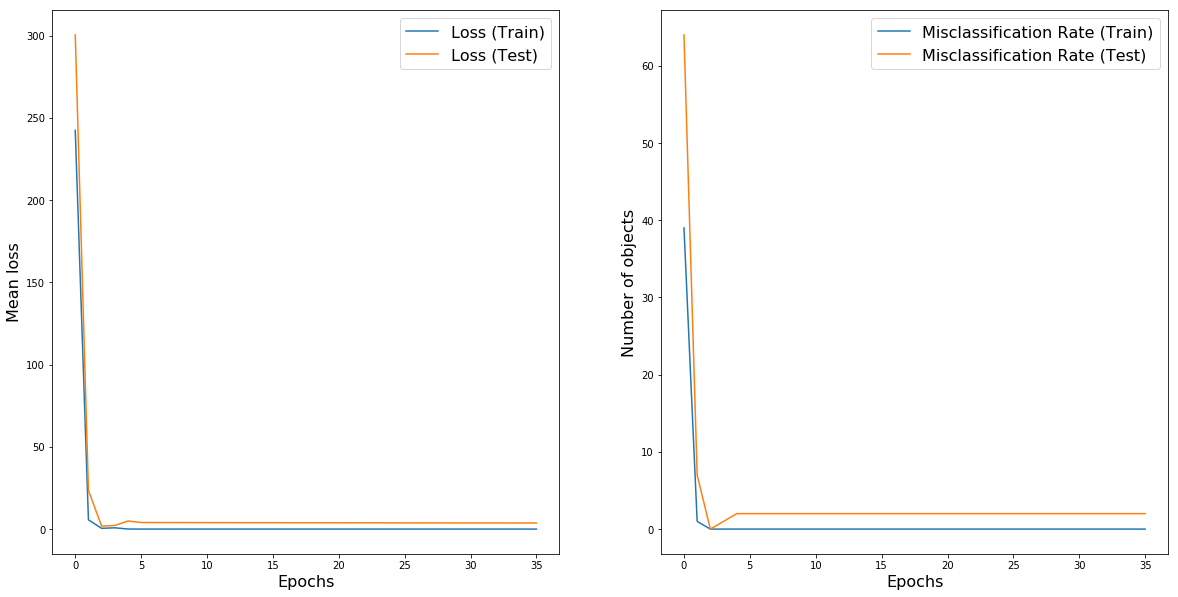

In [420]:
train(net, optimizer, 1000, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

### With Exp Neuron

In [435]:
net_WITH_EXP = Classifier_WITH_EXP(100)
optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=.01)

Epoch 999... Empirical Loss/Misclassification Rate (Train): 0.000/0.000	 Empirical Loss/Misclassification Rate (Test): 176.729/53.0000000

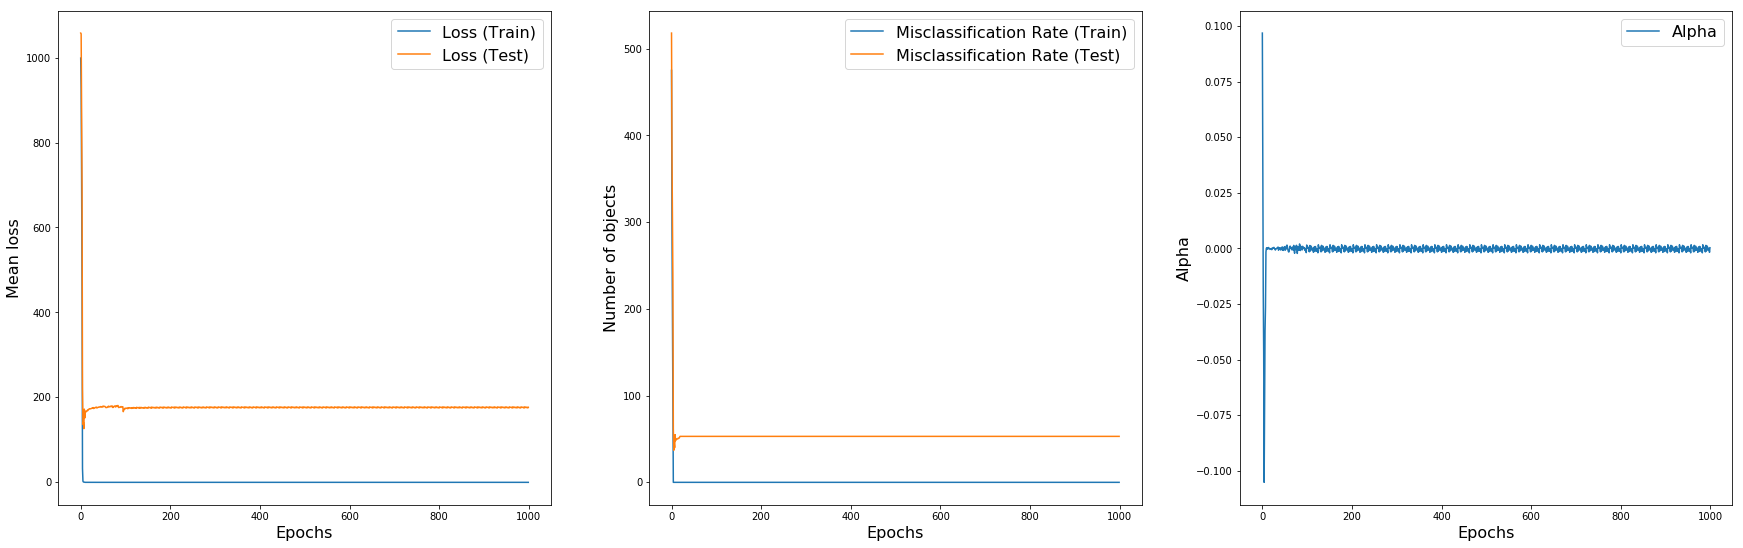

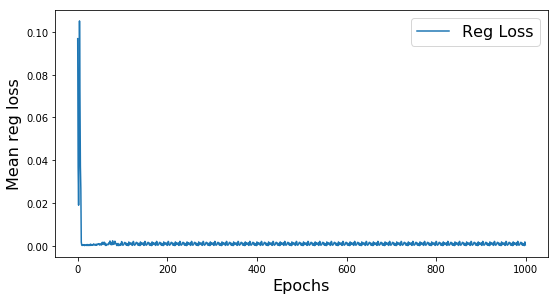

In [436]:
train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=1., epochs=1000, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

In [381]:
net_WITH_EXP = Classifier_WITH_EXP(100)
optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=0.02)

Epoch 611... Empirical Loss/Misclassification Rate (Train): 62.001/0.000	 Empirical Loss/Misclassification Rate (Test): 326.480/4.00000000

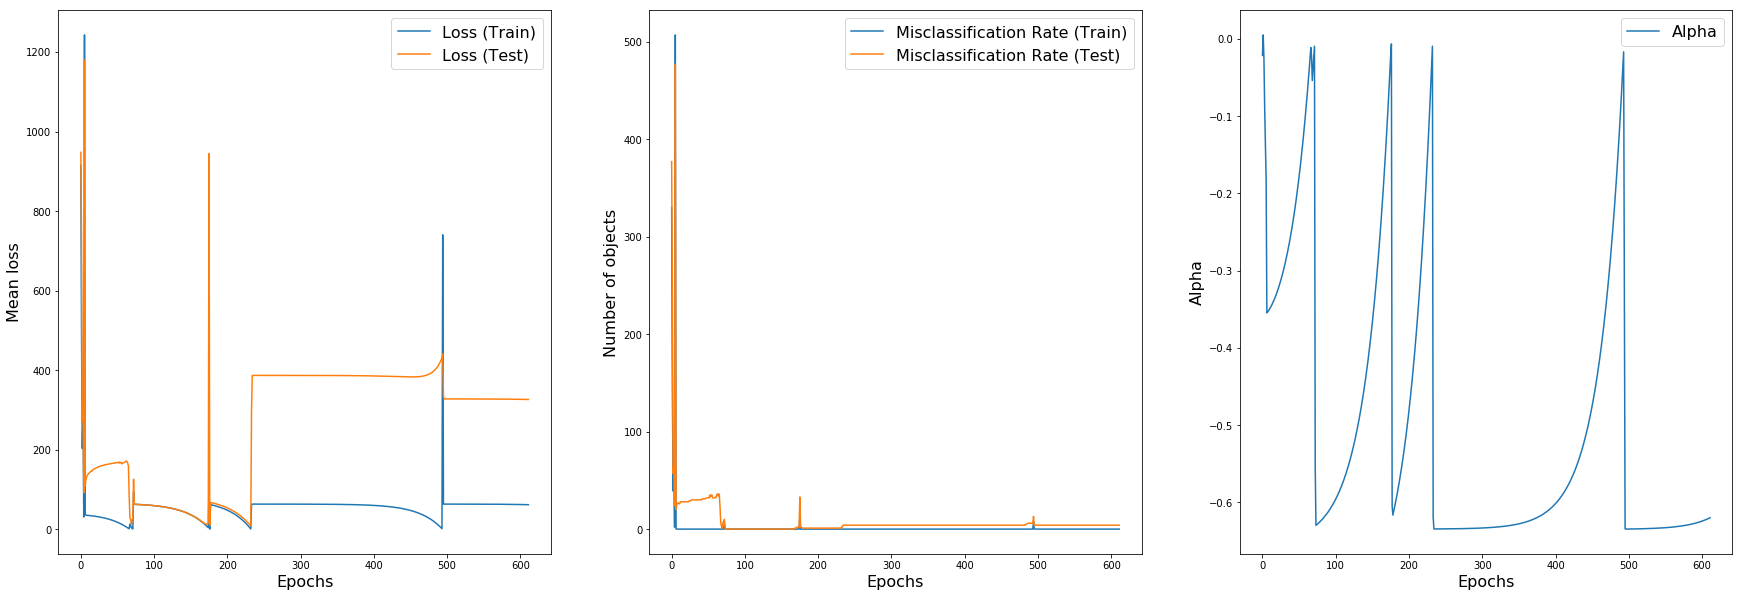

In [382]:
train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=100., epochs=1000, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

In [437]:
net_WITH_EXP = Classifier_WITH_EXP(100)
optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=0.005)

Epoch 999... Empirical Loss/Misclassification Rate (Train): 0.001/0.000	 Empirical Loss/Misclassification Rate (Test): 186.168/12.0000000

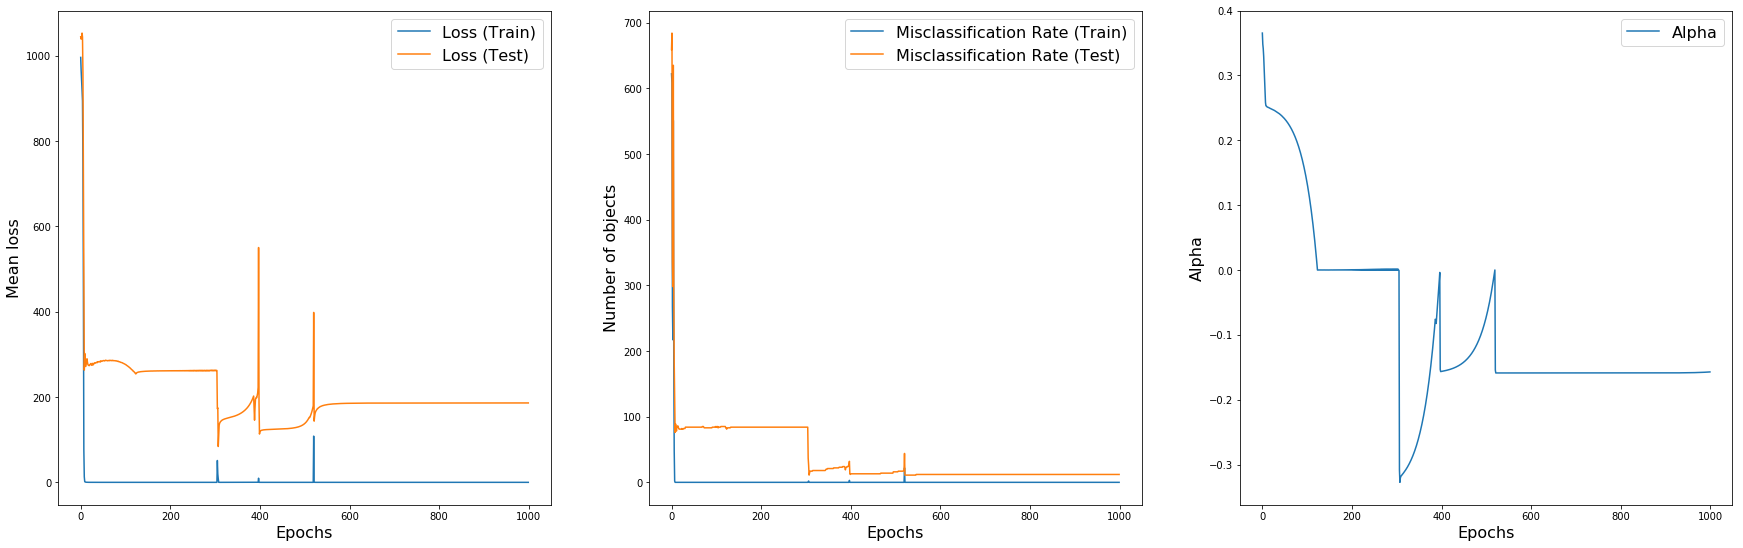

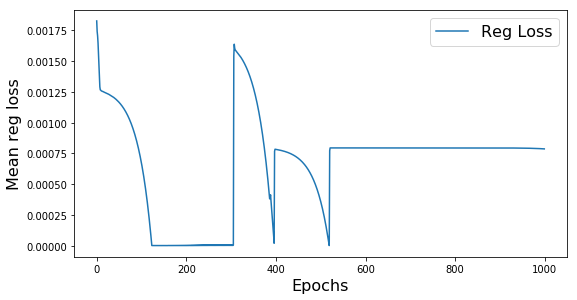

In [438]:
train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=.005, epochs=1000, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

Epoch 99... Empirical Loss/Misclassification Rate (Train): 0.004/0.000	 Empirical Loss/Misclassification Rate (Test): 113.733/20.0000

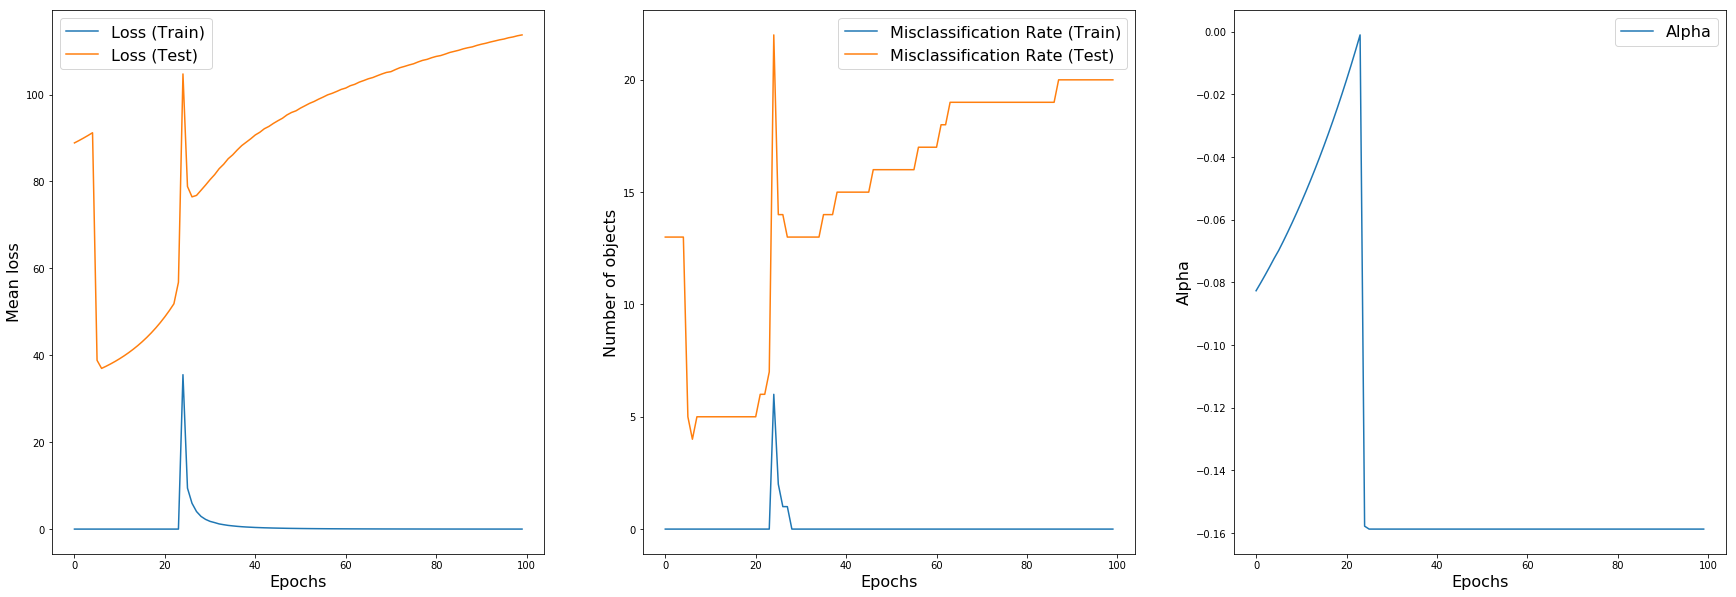

In [391]:
train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=.005, epochs=100, dataloader_train=dataloader_c_train, dataloader_test=dataloader_c_test)

## Two Gaussians

### Without Exp Neuron

Epoch 99... Empirical Loss/Misclassification Rate (Train): 0.000/0.000	 Empirical Loss/Misclassification Rate (Test): 0.029/0.000000

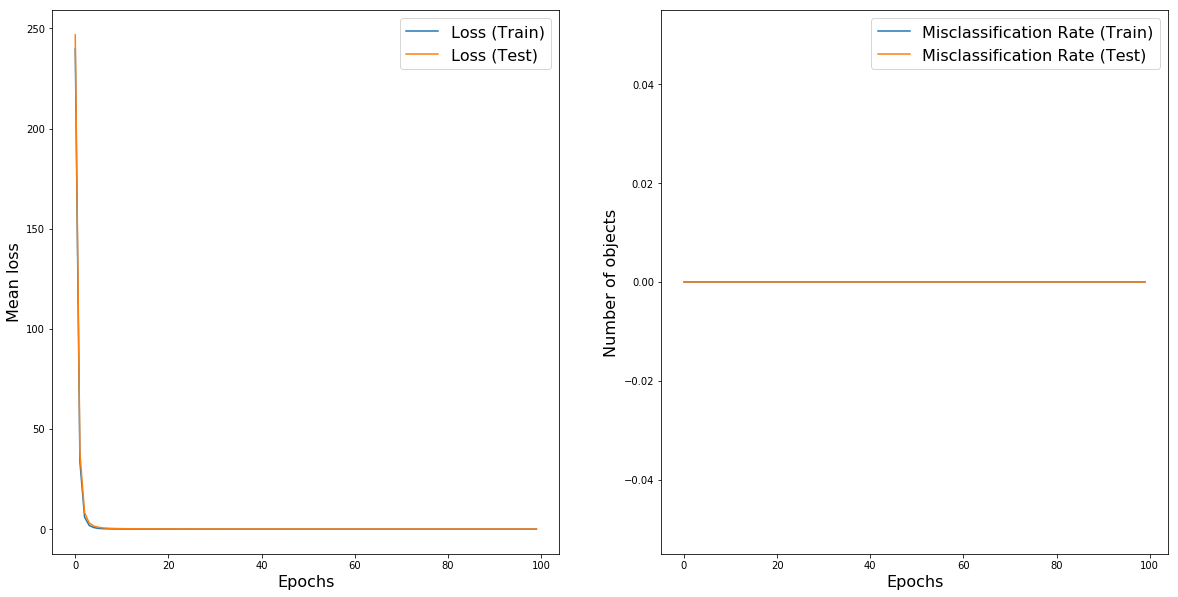

In [394]:
net = Classifier(100)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

train(net, optimizer, 100, dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

### With Exp Neuron

Epoch 599... Empirical Loss/Misclassification Rate (Train): 0.000/0.000	 Empirical Loss/Misclassification Rate (Test): 0.103/0.00000000000

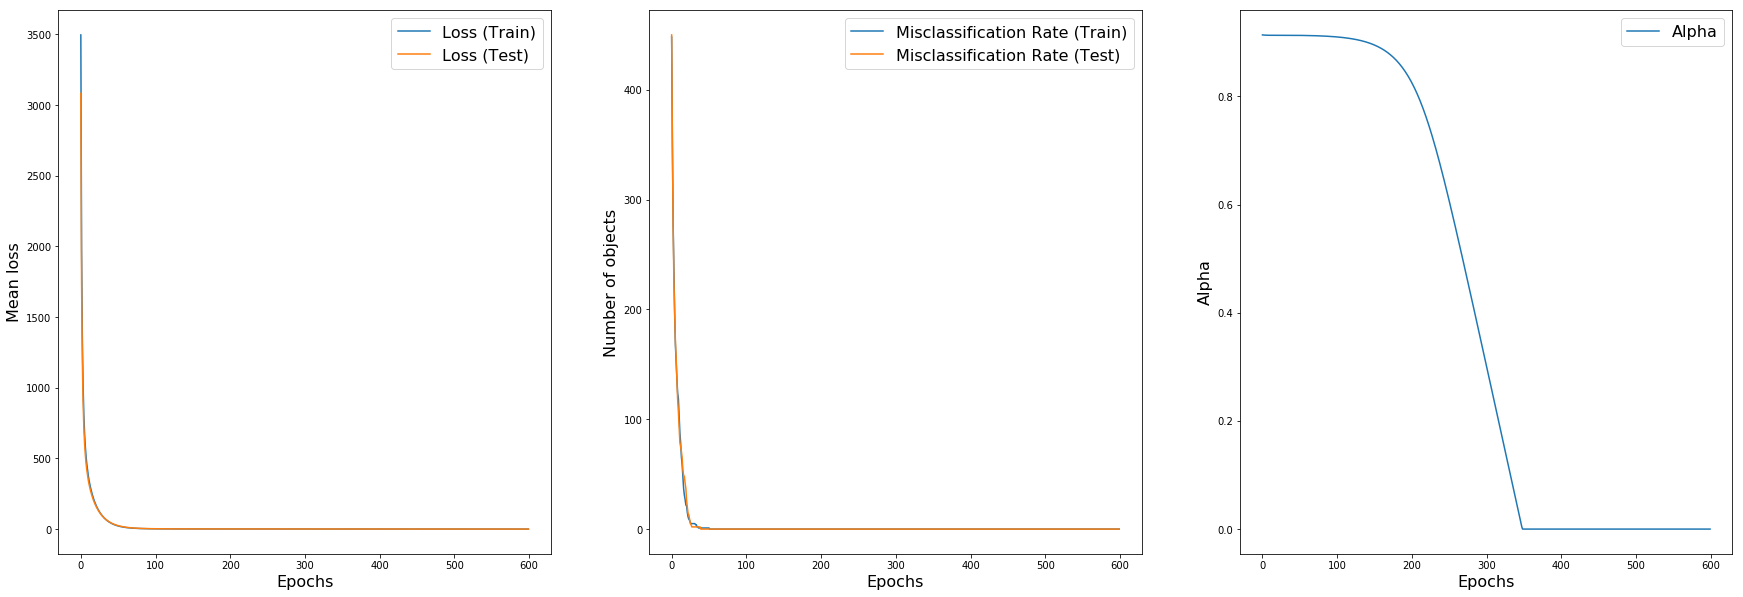

In [399]:
net_WITH_EXP = Classifier_WITH_EXP(100)
optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=0.0001)

train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=1., epochs=600, dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

Epoch 599... Empirical Loss/Misclassification Rate (Train): 0.074/0.000	 Empirical Loss/Misclassification Rate (Test): 1.421/0.0000000

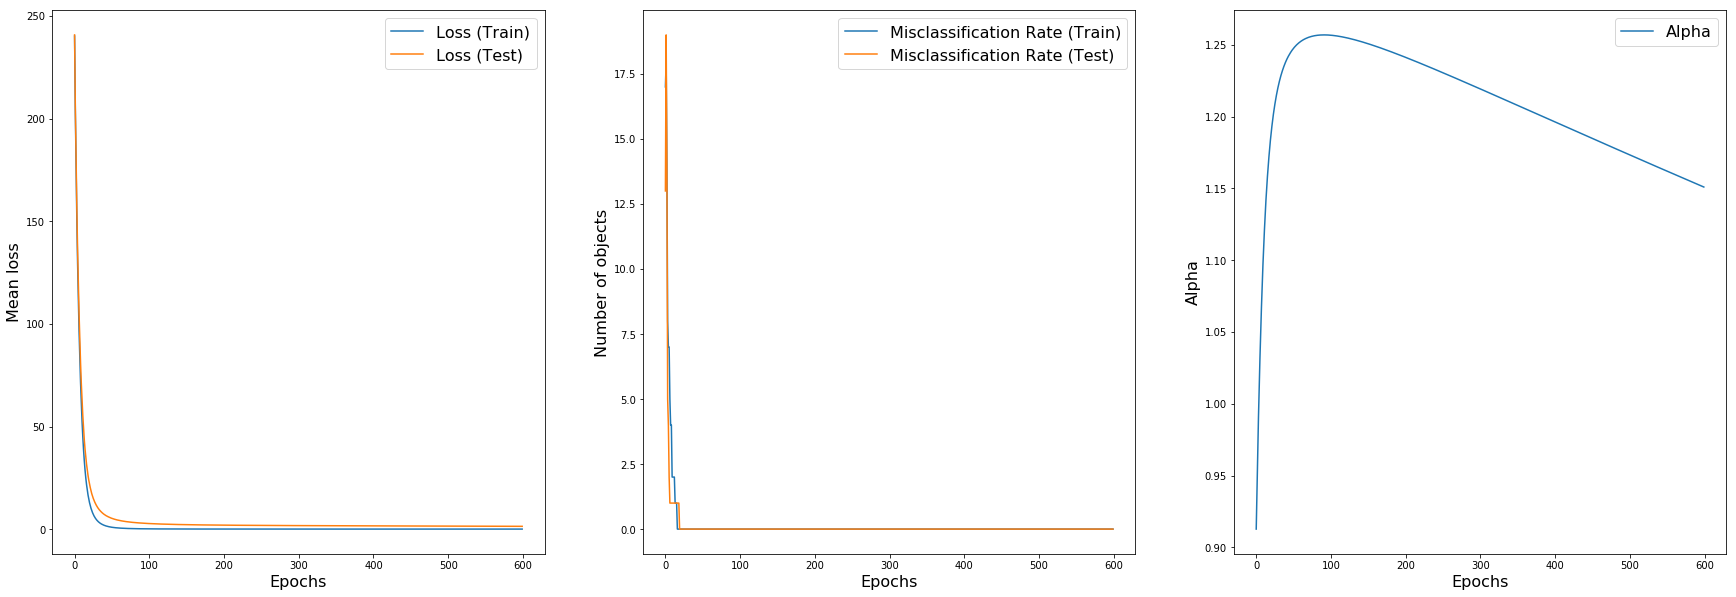

In [403]:
net_WITH_EXP = Classifier_WITH_EXP(100)
optimizer_WITH_EXP = torch.optim.SGD(net_WITH_EXP.parameters(), lr=0.0001)

train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=0.05, epochs=600, dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

Epoch 599... Empirical Loss/Misclassification Rate (Train): 0.016/0.000	 Empirical Loss/Misclassification Rate (Test): 0.414/0.0000000.000

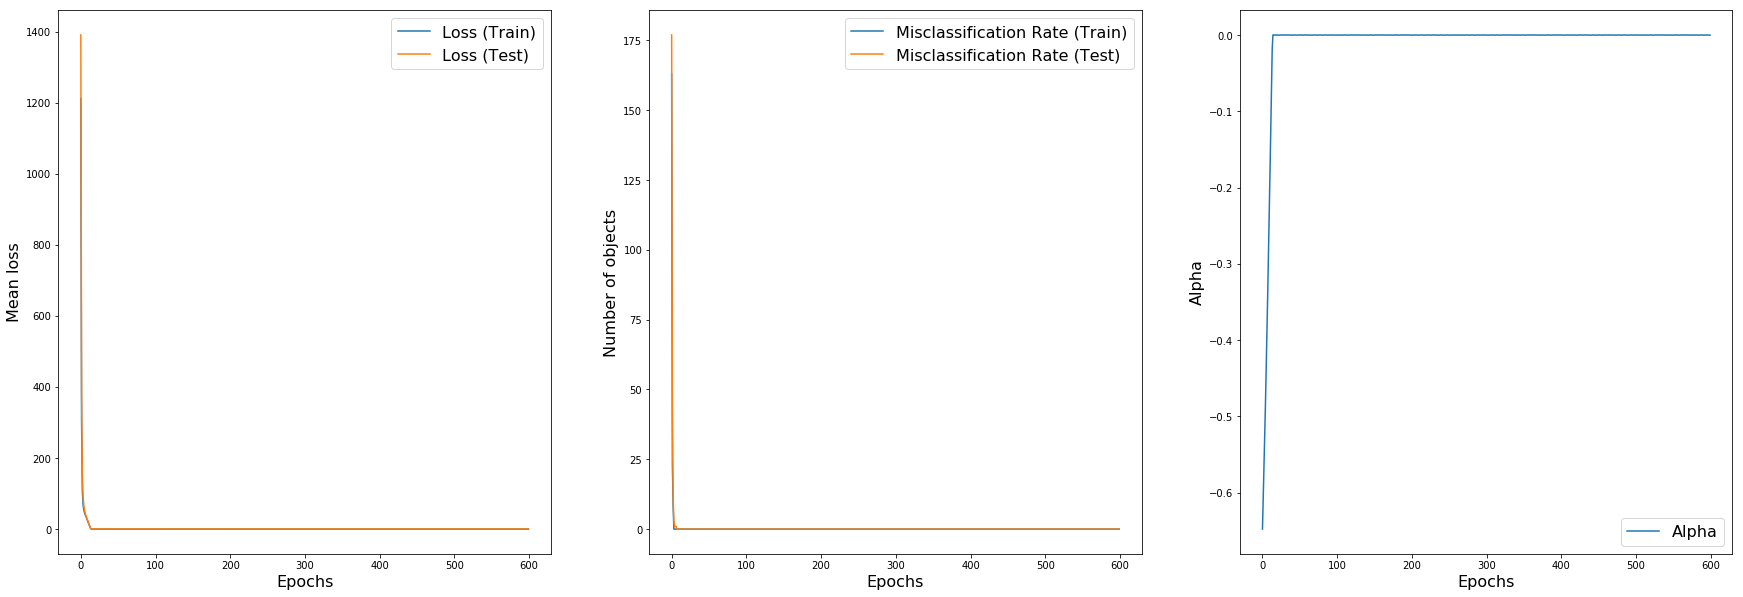

In [405]:
net_WITH_EXP = Classifier_WITH_EXP(100)
optimizer_WITH_EXP = torch.optim.Adam(net_WITH_EXP.parameters(), lr=0.001)

train_WITH_EXP(net_WITH_EXP, optimizer_WITH_EXP, reg_lambda=100., epochs=600, dataloader_train=dataloader_g_train, dataloader_test=dataloader_g_test)

In [79]:
def plot_dataset(dataset, classes = None):
    if classes is None:
        classes = dataset.classes.numpy()
    colors = np.where(classes <= 0, 'k', 'b')
    plt.scatter(dataset.dots[:, 0].numpy(), dataset.dots[:, 1].numpy(), linewidth=0, c=colors)

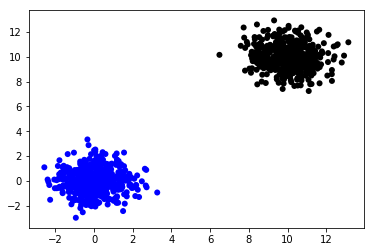

In [80]:
plot_dataset(dataset_g_train, net_WITH_EXP(dataset_g_train.dots).data.numpy())

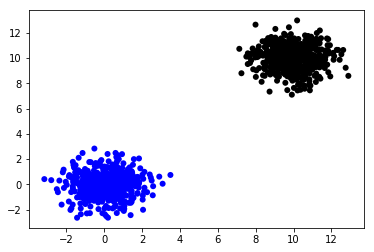

In [81]:
plot_dataset(dataset_g_test, net_WITH_EXP(dataset_g_test.dots).data.numpy())

In [83]:
(np.where(net_WITH_EXP(dataset_g_test.dots).data.numpy() < 0, -1, 1) != dataset_g_test.classes.numpy()).sum()

0

# MNIST

In [188]:
import sys
sys.path.insert(0, './MyMNIST/')
from MyMNIST import MNIST_Class_Selection

In [189]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
dataset_m_train = MNIST_Class_Selection('.', train=True, download=True, transform=transform, class_nums=set([3, 4]))
dataset_m_test = MNIST_Class_Selection('.', train=False, transform=transform, class_nums=set([3, 4]))


dataloader_m_train = DataLoader(dataset_m_train, batch_size=32, shuffle=True)
dataloader_m_test = DataLoader(dataset_m_test, batch_size=32, shuffle=True)

In [190]:
def train_conv(network, optimizer, epochs, dataloader_train, dataloader_test):
    def loss_func(predict_y, correct_y):
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        return loss
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    try:
        for epoch in xrange(epochs):
            losses_train_batch = []
            losses_test_batch = []
            misscl_rate_train_batch = []
            misscl_rate_test_batch = []
            
            # train
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())

                predict_y = network(x)
                loss = loss_func(predict_y, correct_y)
                #print(loss, correct_y, predict_y)
                losses_train_batch.append(loss.data.clone())
                misscl_rate_train_batch.append((np.where(predict_y.data.clone().numpy() < 0, -1, 1) != correct_y.data.clone().numpy()).sum())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # test
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())

                predict_y = network(x)
                loss = loss_func(predict_y, correct_y)
                losses_test_batch.append(loss.data.clone())
                misscl_rate_test_batch.append((np.where(predict_y.data.clone().numpy() < 0, -1, 1) != correct_y.data.clone().numpy()).sum())
                
            losses_train.append(sum(losses_train_batch)/len(losses_train_batch))
            misscl_rate_train.append(sum(misscl_rate_train_batch))
            losses_test.append(sum(losses_test_batch)/len(losses_test_batch))
            misscl_rate_test.append(sum(misscl_rate_test_batch))

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(losses_train, label='Loss (Train)')
    plt.plot(losses_test, label='Loss (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Mean loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.subplot(1, 2, 2)
    plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
    plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Number of objects', fontsize=16)
    plt.legend(loc=0, fontsize=16)

In [191]:
def train_conv_WITH_EXP(network, optimizer, reg_lambda, epochs, dataloader_train, dataloader_test):
    def loss_func(predict_y, correct_y, network, reg_lambda):
        loss = torch.sum(torch.max(-correct_y * predict_y + torch.tensor([1.]), torch.tensor([0.])) ** 3)
        for param in net_WITH_EXP.explinear.alpha.parameters():
            loss += reg_lambda * param.norm(2)
        return loss
    alpha = []
    losses_train = []
    losses_test = []
    misscl_rate_train = []
    misscl_rate_test = []
    try:
        for epoch in xrange(epochs):
            losses_train_batch = []
            losses_test_batch = []
            misscl_rate_train_batch = []
            misscl_rate_test_batch = []
            
            # train
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())

                predict_y = network(x)
                loss = loss_func(predict_y, correct_y, network, reg_lambda)
                #print(loss, correct_y, predict_y)
                losses_train_batch.append(loss.data.clone())
                misscl_rate_train_batch.append((np.where(predict_y.data.clone().numpy() < 0, -1, 1) != correct_y.data.clone().numpy()).sum())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # test
            for batch_dots, batch_labels in dataloader_train:
                x = Variable(batch_dots)
                correct_y = Variable(batch_labels.float())

                predict_y = network(x)
                loss = loss_func(predict_y, correct_y, network, reg_lambda)
                losses_test_batch.append(loss.data.clone())
                misscl_rate_test_batch.append((np.where(predict_y.data.clone().numpy() < 0, -1, 1) != correct_y.data.clone().numpy()).sum())
             
            alpha.append(network.get_alpha())   
            losses_train.append(sum(losses_train_batch)/len(losses_train_batch))
            misscl_rate_train.append(sum(misscl_rate_train_batch))
            losses_test.append(sum(losses_test_batch)/len(losses_test_batch))
            misscl_rate_test.append(sum(misscl_rate_test_batch))

            sys.stdout.write('\rEpoch {0}... Empirical Loss/Misclassification Rate (Train): {1:.3f}/{2:.3f}\t Empirical Loss/Misclassification Rate (Test): {3:.3f}/{4:.3f}'.format(
                            epoch, losses_train[-1], misscl_rate_train[-1], losses_test[-1], misscl_rate_test[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(30, 10))
    plt.subplot(1, 3, 1)
    plt.plot(losses_train, label='Loss (Train)')
    plt.plot(losses_test, label='Loss (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Mean loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.subplot(1, 3, 2)
    plt.plot(misscl_rate_train, label='Misclassification Rate (Train)')
    plt.plot(misscl_rate_test, label='Misclassification Rate (Test)')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Number of objects', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.subplot(1, 3, 3)
    plt.plot(alpha, label='Alpha')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Alpha', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    return alpha

In [192]:
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 128, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(128, 256, 4, padding=1),
            nn.PReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.linear_layers(x).view(-1)

In [193]:
class ConvClassifier_WITH_EXP(nn.Module):
    def __init__(self, in_size):
        super(ConvClassifier_WITH_EXP, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(64, 128, 4, padding=1),
            nn.PReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(128, 256, 4, padding=1),
            nn.PReLU(),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(256, 1)
        )
        self.explinear = ExpLinear(in_size)
    
    def forward(self, x):
        y = self.explinear(x.view(x.shape[0], -1)).view(-1)
        x = self.conv_layers(x)
        x = x.view(x.shape(0), -1)
        return self.linear_layers(x).view(-1) + y
    
    # get parameter alpha from explinear block
    def get_alpha(self):
        return dict(self.explinear.alpha.named_parameters())['0.weight'].data.clone().numpy()[0, 0]

In [47]:
net_m = ConvClassifier()
optimizer_m = torch.optim.SGD(net_m.parameters(), lr=0.00001)

Epoch 19... Empirical Loss/Misclassification Rate (Train): 0.380/27.000	 Empirical Loss/Misclassification Rate (Test): 0.372/31.00000

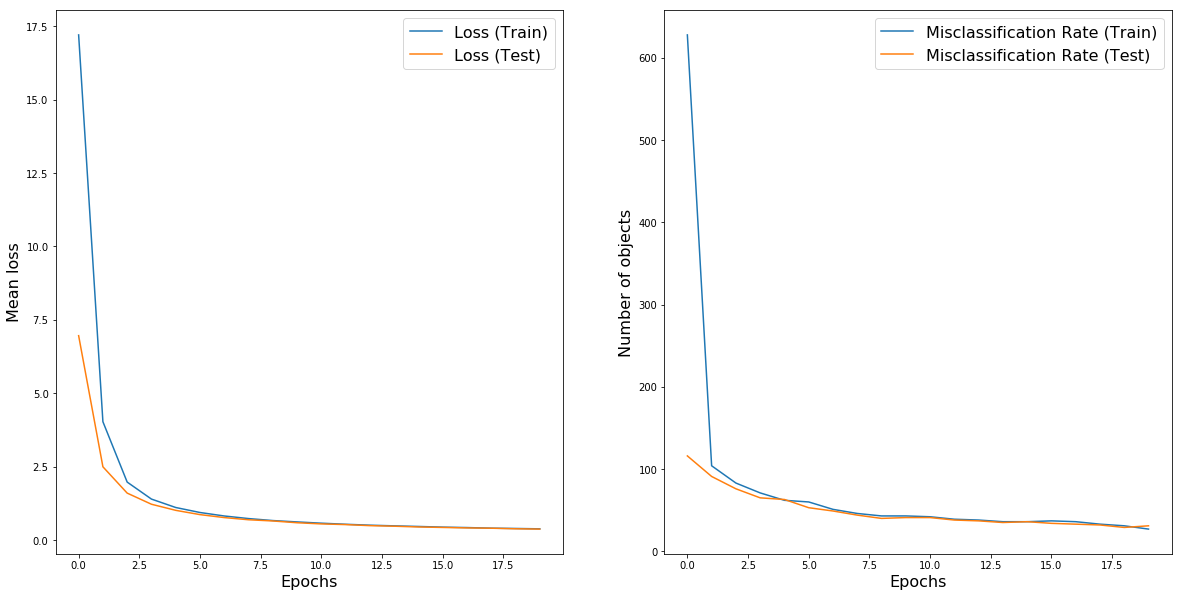

In [18]:
train_conv(net_m, optimizer_m, 20, dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test)

In [201]:
net_WITH_EXP_m = ConvClassifier_WITH_EXP(28 * 28)
optimizer_WITH_EXP_m = torch.optim.SGD(net_WITH_EXP_m.parameters(), lr=0.00001)

Epoch 0... Empirical Loss/Misclassification Rate (Train): nan/554.000	 Empirical Loss/Misclassification Rate (Test): nan/211.000

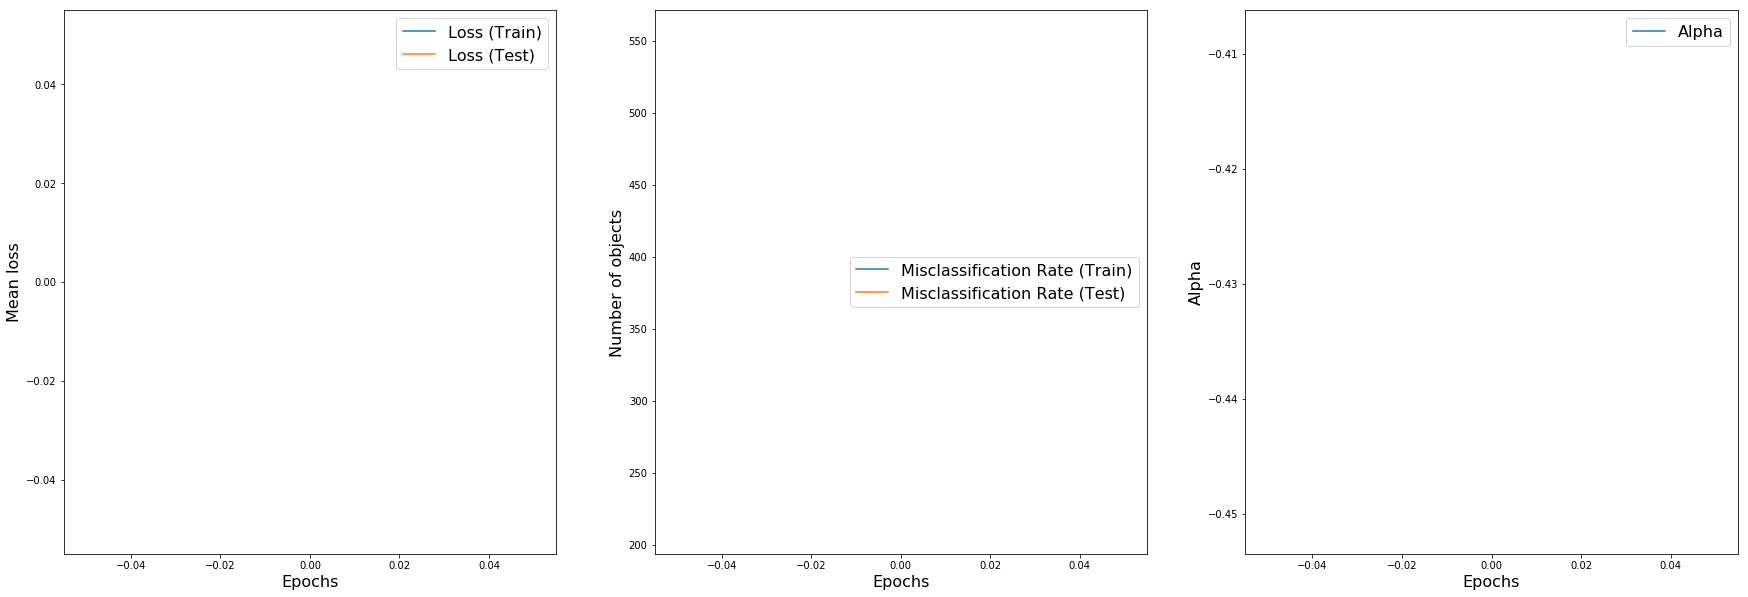

In [202]:
alpha = train_conv_WITH_EXP(net_WITH_EXP_m, optimizer_WITH_EXP_m, reg_lambda=0.0, epochs=20, dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test)

In [205]:
for param in net_WITH_EXP_m.explinear.parameters():
    print param

Parameter containing:
tensor(1.00000e-02 *
       [[ 0.6222,  2.3358,  1.4498, -0.2063,  1.9390,  2.1820, -2.8580,
          2.2663,  0.7682,  2.2400, -2.5322,  1.3390, -2.6967,  1.2838,
         -0.7391,  2.8618, -2.7473,  2.1114,  2.6463,  2.0772, -0.9668,
          1.2735,  1.5052,  2.3860, -2.5412, -0.9965, -2.9972,  0.0211,
          1.5632,  0.6916, -0.4830,  0.3930, -2.2659, -2.1667, -1.1342,
         -0.2510, -3.5225,  2.5437, -1.8156,  0.5843, -0.5330,  0.7246,
         -2.9873, -2.5658, -3.4527, -2.3265,  3.2826, -0.8011, -0.1234,
          1.4477, -1.5207,  0.2193, -3.5775, -0.1266, -2.3394,  1.9529,
          2.8765,  2.9002, -2.0334,  2.7513, -0.6569, -2.5424,  0.1553,
         -2.0852,  2.2816, -1.9856, -2.8320, -2.9665,  3.2667,  3.1888,
          1.3413, -3.4492,  1.1832,  2.4789,  1.0854,  3.3752,  1.9752,
         -1.9597, -0.9298, -3.4267, -2.3305, -2.4527, -1.0977, -0.5379,
          0.1636,  0.8930, -0.4652,  2.6154, -2.7157,  2.2256,  3.0304,
         -0.6978, -1.

In [211]:
class AugActivation(nn.Module):
    def __init__(self, base_activation):
        super(AugActivation, self).__init__()
        self.base_activation = base_activation
        self.exp_activation = torch.exp
        
    def forward(self, x):
        y_1 = self.base_activation(x[:, :-1])
        y_2 = self.exp_activation(x[:, -1:])
        return torch.cat([y_1, y_2], dim=1)

In [212]:
gg = AugActivation(nn.PReLU())

In [225]:
x = Variable(torch.Tensor([[1,2,3,4], [5,6,7,8], [9, 10, 11, 12]]), requires_grad=True)

In [226]:
x

tensor([[  1.,   2.,   3.,   4.],
        [  5.,   6.,   7.,   8.],
        [  9.,  10.,  11.,  12.]])

In [227]:
y = gg(x).norm(2)

In [228]:
y.backward()

In [230]:
print x.grad

tensor([[ 6.1432e-06,  1.2286e-05,  1.8430e-05,  1.8313e-02],
        [ 3.0716e-05,  3.6859e-05,  4.3002e-05,  5.4589e+01],
        [ 5.5289e-05,  6.1432e-05,  6.7575e-05,  1.6273e+05]])
